# Conv1D Model Approach

## Read Data from CSV File

In [1]:
# Read Data
import pandas as pd
import numpy as np
import os

data = pd.read_csv('./questions.csv')

data.question1 = data.question1.astype(str)
data.question2 = data.question2.astype(str)

questions_1 = data.question1
questions_2 = data.question2
is_duplicate = data.is_duplicate
num_of_records = len(data)

## Preprocess Data
We will pad all sentences to 250 characters and tokenize them.

In [2]:
# Preprocess Data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 250

def get_sequences_padded(input_texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(input_texts)
    seq = tokenizer.texts_to_sequences(input_texts)
    seq = pad_sequences(seq, maxlen=maxlen)
    return seq

labels = np.asarray(is_duplicate).astype('float32')
questions_1_sequences = get_sequences_padded(questions_1)
questions_2_sequences = get_sequences_padded(questions_2)

print('Shape of questions_1_sequences tensor:', questions_1_sequences.shape)
print('Shape of questions_2_sequences tensor:', questions_2_sequences.shape)
print('Shape of labels tensor:', labels.shape)

/Users/harsimranb/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Shape of questions_1_sequences tensor: (404351, 250)
Shape of questions_2_sequences tensor: (404351, 250)
Shape of labels tensor: (404351,)


Now we will distribute the test and train size.  The test data will be 30% of the total data.
We also reshape the vector and combine question 1 and 2 dimension into 1 dimension.

In [4]:
# Combine Questions 1 And 2 Into an input with multiple dimensions
test_size = int(num_of_records * 0.3)
train_size = num_of_records-test_size

train_data = np.ones((2, train_size, maxlen))
test_data = np.ones((2, test_size, maxlen))

train_data[0] = questions_1_sequences[test_size:]
train_data[1] = questions_2_sequences[test_size:]
test_data[0] = questions_1_sequences[:test_size]
test_data[1] = questions_2_sequences[:test_size]
train_labels = labels[test_size:]
test_labels = labels[:test_size]

# Swap 0 and 1 axis, so number of examples is axis 0.
train_data = np.swapaxes(train_data, 1, 0)
test_data = np.swapaxes(test_data, 1, 0)

# Reshape
train_data = train_data.reshape(train_size, 2 * 250)
test_data = test_data.reshape(test_size, 2 * 250)

print('Shape of train tensor:', train_data.shape)
print('Shape of test tensor:', test_data.shape)

Shape of train tensor: (283046, 500)
Shape of test tensor: (121305, 500)


## Build Model
Here we will build a small dense model for training.

In [8]:
# Build Model and Train
from keras.models import Sequential
from keras.optimizers import RMSprop
import keras.layers as layers

model = Sequential()
model.add(layers.Embedding(train_size, 64, input_length=500))
# model.add(layers.Conv1D(32, 7, activation='relu'))
# model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
model.save('embedding_Conv1D.h5')

Train on 226436 samples, validate on 56610 samples
Epoch 1/10
226436/226436 [==============================] - 654s 3ms/step - loss: 0.6038 - acc: 0.6742 - val_loss: 0.5577 - val_acc: 0.7218
Epoch 2/10
226436/226436 [==============================] - 1035s 5ms/step - loss: 0.5529 - acc: 0.7277 - val_loss: 0.5492 - val_acc: 0.7349
Epoch 3/10
226436/226436 [==============================] - 651s 3ms/step - loss: 0.5382 - acc: 0.7419 - val_loss: 0.5592 - val_acc: 0.7415
Epoch 4/10
226436/226436 [==============================] - 635s 3ms/step - loss: 0.5246 - acc: 0.7515 - val_loss: 0.5468 - val_acc: 0.7465
Epoch 5/10
226436/226436 [==============================] - 634s 3ms/step - loss: 0.5126 - acc: 0.7590 - val_loss: 0.5467 - val_acc: 0.7474
Epoch 6/10
226436/226436 [==============================] - 636s 3ms/step - loss: 0.5008 - acc: 0.7666 - val_loss: 0.5602 - val_acc: 0.7527
Epoch 7/10
226436/226436 [==============================] - 628s 3ms/step - loss: 0.4897 - acc: 0.7731 - val

## Evaludate Model
Upon evaluation of the current model, we reach a decent training and validation accuracy, of ~79%
The loss is also faily low and consistent.  However, our model might be overfitting a bit because training loss and validation loss diverge a bit.

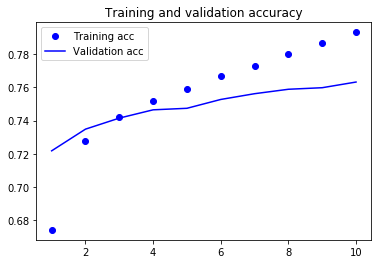

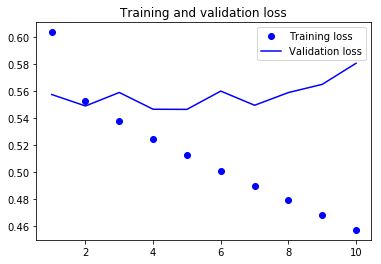

In [10]:
# Plot for Evaluation
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test Data
Now we will run model on test data, and with this Conv1D model, we get 75% accuracy.

In [11]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

121305/121305 [==============================] - 90s 740us/step
test_acc: 0.7572565022022371
test_loss: 0.5941898419612228
